In [59]:
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta
import shrimpy
import psycopg2

In [60]:
class DatabaseClient:
    """
    Functionality for inserting and reading from the database
    """

    def __init__(self):
        # Connect to db
        self.con = psycopg2.connect(
            host='localhost',
            database='postgres',
            user='postgres',
            password='postgres'
        )
        self.article_table = pd.DataFrame()

    def read_db(self):
        cur = self.con.cursor()

        cur.execute("SELECT timestamp, comp_sentiment, sma, ema FROM sent_values WHERE timestamp > '2021-01-26 15:00:00'::timestamp;")

        rows = cur.fetchall()

        self.article_table = pd.DataFrame(data=rows, columns=['timestamp','compound','sma','ema'])


        return self.article_table

In [61]:
def get_latest_prices(trading_symbol):
    public_key = '12326758a39a720e15d064cab3c1f0a9332d107de453bd41926bb3acd565059e'
    secret_key = '6991cf4c9b518293429db0df6085d1731074bed8abccd7f0279a52fac5b0c1a8a2f6d28e11a50fbb1c6575d1407e637f9ad7c73fbddfa87c5d418fd58971f829'
    
    client = shrimpy.ShrimpyApiClient(public_key, secret_key)
        
    # get the candles for historical values
    candles = client.get_candles(
        'binance',  # exchange
        trading_symbol,      # base_trading_symbol
        'USDT',      # quote_trading_symbol
        '1h'       # interval
    )
        
    # Set the dataframe between these two dates
    tomorrows_date = (datetime.today() - timedelta(hours=1)).strftime("%Y-%m-%d %H:00")
    tomorrows_date = (datetime.today()).strftime("%Y-%m-%d %H:00")
    starting_date = '2021-01-25 02:00:00'

    # Put pulled cryptocurrency values into a dataframe and set dates
    prices_df = pd.DataFrame(candles)
    prices_df['time'] = pd.to_datetime(prices_df['time'], infer_datetime_format=True).dt.tz_localize(None)

    latest_prices = prices_df[(prices_df['time'] > starting_date) & (prices_df['time'] <tomorrows_date)]
    latest_prices['close'] = latest_prices['close'].astype('float64')

    return latest_prices

In [62]:
database_client = DatabaseClient()
df = database_client.read_db()
df.index = df.timestamp
df = df.iloc[:-1]

data = get_latest_prices('BTC')
data.index = data.time
data = data.iloc[:-4]

dataset_train = data.join(df, lsuffix=data.index, rsuffix=df.index)

dataset_train = dataset_train[['close', 'sma']]
dataset_train = dataset_train.dropna()
stk_data = dataset_train.astype('float')

stk_data.count()

close    918
sma      918
dtype: int64

In [79]:
#Data Preprocessing
stk_data['Date'] = stk_data.index
data2 = pd.DataFrame(columns = ['Date', 'Close'])
data2['Date'] = stk_data['Date']
data2['Close'] = stk_data['close']
data2['SMA'] = stk_data['sma']

train_set = data2.iloc[:857, 1:3].values
valid_set = data2.iloc[857:, 1:3].values

sc_train = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc_train.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, len(train_set)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

sc_valid = MinMaxScaler(feature_range = (0, 1))
valid_set_scaled = sc_valid.fit_transform(valid_set)
X_valid = []
y_valid = []
for i in range(60, len(valid_set)):
    X_valid.append(valid_set_scaled[i-60:i, 0])
    y_valid.append(valid_set_scaled[i, 0]) 
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [80]:
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 100))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

In [81]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

#es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = regressor.fit(X_train, y_train, epochs = 100, callbacks=[rlr, mcp, tb], validation_data=(X_valid, y_valid), batch_size = 1)

Epoch 1/100
797/797 [==============================] - 40s 44ms/step - loss: 0.0409 - val_loss: 0.0401

Epoch 00001: val_loss improved from inf to 0.04011, saving model to weights.h5
Epoch 2/100
797/797 [==============================] - 27s 34ms/step - loss: 0.0088 - val_loss: 0.0294

Epoch 00002: val_loss improved from 0.04011 to 0.02941, saving model to weights.h5
Epoch 3/100
797/797 [==============================] - 27s 34ms/step - loss: 0.0060 - val_loss: 0.0330

Epoch 00003: val_loss did not improve from 0.02941
Epoch 4/100
797/797 [==============================] - 27s 34ms/step - loss: 0.0052 - val_loss: 0.0814

Epoch 00004: val_loss did not improve from 0.02941
Epoch 5/100
797/797 [==============================] - 27s 34ms/step - loss: 0.0056 - val_loss: 0.0458

Epoch 00005: val_loss did not improve from 0.02941
Epoch 6/100
797/797 [==============================] - 27s 34ms/step - loss: 0.0055 - val_loss: 0.0474

Epoch 00006: val_loss did not improve from 0.02941
Epoch 7/10

797/797 [==============================] - 27s 34ms/step - loss: 0.0014 - val_loss: 0.0428

Epoch 00051: val_loss did not improve from 0.02941
Epoch 52/100
797/797 [==============================] - 27s 34ms/step - loss: 0.0012 - val_loss: 0.0403

Epoch 00052: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00052: val_loss did not improve from 0.02941
Epoch 53/100
797/797 [==============================] - 27s 34ms/step - loss: 0.0011 - val_loss: 0.0420

Epoch 00053: val_loss did not improve from 0.02941
Epoch 54/100
797/797 [==============================] - 27s 34ms/step - loss: 0.0012 - val_loss: 0.0426

Epoch 00054: val_loss did not improve from 0.02941
Epoch 55/100
797/797 [==============================] - 27s 34ms/step - loss: 0.0012 - val_loss: 0.0412

Epoch 00055: val_loss did not improve from 0.02941
Epoch 56/100
797/797 [==============================] - 27s 34ms/step - loss: 0.0012 - val_loss: 0.0409

Epoch 00056: val_loss did not improve from 0.02

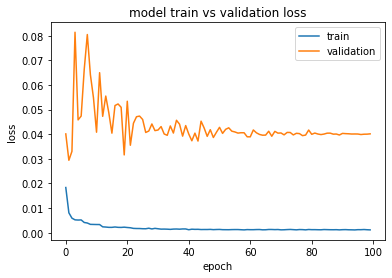

In [82]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [83]:
#predicting 246 values, using past 60 from the train data
inputs = data2.iloc[len(data2) - len(valid_set) - 60:,1:3].values
inputs = inputs.reshape(-inputs.shape[1],inputs.shape[1])
inputs  = sc_valid.transform(inputs)

In [84]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [85]:
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
closing_price = regressor.predict(X_test)

# invert scaling for forecast
inv_yhat = np.concatenate((closing_price,X_test[:,-2]), axis=1)
closing_price = sc_valid.inverse_transform(inv_yhat)

In [86]:
lstm_sma_rms=np.sqrt(np.mean(np.power((valid_set-closing_price),2)))
lstm_sma_rms

230.0781865219993

<ipython-input-88-43d1a38121af>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price[:,0]


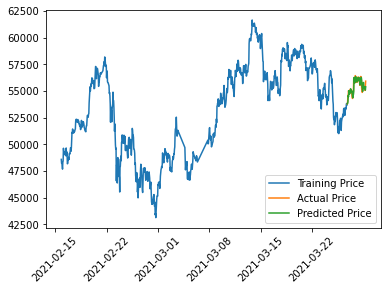

In [88]:
#for plotting
train = data2[:857]
valid = data2[857:]
valid['Predictions'] = closing_price[:,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.xticks(rotation=45)

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

In [89]:
valid.count()

Date           61
Close          61
SMA            61
Predictions    61
dtype: int64

In [90]:
valid['Previous'] = valid['Close'].shift(1)
valid['Previous_SMA'] = valid['SMA'].shift(1)
valid

<ipython-input-90-5da401a91f12>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Previous'] = valid['Close'].shift(1)
<ipython-input-90-5da401a91f12>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Previous_SMA'] = valid['SMA'].shift(1)


,Date,Close,SMA,Predictions,Previous,Previous_SMA
time,,,,,,
2021-03-26 19:00:00,2021-03-26 19:00:00,53778.55,0.0504,53795.904808,NaN,NaN
2021-03-26 20:00:00,2021-03-26 20:00:00,53960.00,0.1669,53831.750102,53778.55,0.0504
2021-03-26 21:00:00,2021-03-26 21:00:00,54574.41,-0.1167,53971.772661,53960.00,0.1669
2021-03-26 22:00:00,2021-03-26 22:00:00,54383.14,-0.1167,54560.884543,54574.41,-0.1167
2021-03-26 23:00:00,2021-03-26 23:00:00,55025.59,-0.1167,54452.076667,54383.14,-0.1167
...,...,...,...,...,...,...
2021-03-29 03:00:00,2021-03-29 03:00:00,55371.60,0.5900,55344.562123,55349.99,0.5900
2021-03-29 04:00:00,2021-03-29 04:00:00,55315.01,0.5900,55380.912085,55371.60,0.5900
2021-03-29 05:00:00,2021-03-29 05:00:00,55048.80,0.5900,55318.490315,55315.01,0.5900


In [91]:
valid[((valid.Previous > valid.Predictions) & (valid.Previous > valid.Close)) | ((valid.Previous < valid.Predictions) & (valid.Previous < valid.Close))].count() 

Date            35
Close           35
SMA             35
Predictions     35
Previous        35
Previous_SMA    35
dtype: int64

In [92]:
valid[((valid.SMA != valid.Previous_SMA))].count()

Date            21
Close           21
SMA             21
Predictions     21
Previous        20
Previous_SMA    20
dtype: int64

In [93]:
df = valid[((valid.SMA != valid.Previous_SMA))]

In [94]:
df[((valid.Previous > valid.Predictions) & (valid.Previous > valid.Close)) | ((valid.Previous < valid.Predictions) & (valid.Previous < valid.Close))].count() 

<ipython-input-94-a5f011599084>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[((valid.Previous > valid.Predictions) & (valid.Previous > valid.Close)) | ((valid.Previous < valid.Predictions) & (valid.Previous < valid.Close))].count()


Date            9
Close           9
SMA             9
Predictions     9
Previous        9
Previous_SMA    9
dtype: int64

In [95]:
df.count()

Date            21
Close           21
SMA             21
Predictions     21
Previous        20
Previous_SMA    20
dtype: int64